# Finetuning: analyze F1 changes

We tried 2 modifications to finetune trainer.py
1. Move csvlogger to last in the callback list
2. Save output of model.fit() to npy file

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
PROJECT_ROOT = '/content/drive/MyDrive/DLHProject'

Note that JOB_DIR below was created by `jupyter_notebooks/finetune_train_random_original_with_f1.ipynb`

This only runs 10 epochs of finetuning on random initialized data.

In [4]:
JOB_DIR = PROJECT_ROOT + '/jobs/finetune_random_cnn_original_data_with_f1'
! ls -lh $JOB_DIR

total 52M
-rw------- 1 root root  52M Apr 11 06:24 best_model.weights.data-00000-of-00001
-rw------- 1 root root  14K Apr 11 06:24 best_model.weights.index
-rw------- 1 root root   93 Apr 11 06:24 checkpoint
-rw------- 1 root root 1013 Apr 11 06:21 history.csv
-rw------- 1 root root 1023 Apr 11 06:25 history.npy
-rw------- 1 root root 103K Apr 11 06:25 test_predictions.csv
-rw------- 1 root root 386K Apr 11 06:25 train_predictions.csv
-rw------- 1 root root  26K Apr 11 06:25 val_predictions.csv


In [5]:
%cd $JOB_DIR

/content/drive/.shortcut-targets-by-id/1vlUILM7cToH5CoX1x0kWRpe55MbBogS-/Project/jobs/finetune_random_cnn_original_data_with_f1


In [6]:
! head history.csv

epoch,acc,f1,loss,val_acc,val_loss
0,0.6012510061264038,0.40085603011134924,0.9432749152183533,0.6088992953300476,0.9500560760498047
1,0.6783424615859985,0.6145307633171481,0.7665732502937317,0.7213114500045776,0.6366396546363831
2,0.7133698463439941,0.4177190766723688,0.6997089982032776,0.6487119197845459,0.8629630208015442
3,0.729163408279419,0.5907259013641992,0.6475918889045715,0.7306791543960571,0.714259684085846
4,0.7354183197021484,0.6690685741572123,0.6315167546272278,0.7494145035743713,0.6611289978027344
5,0.7560594081878662,0.601569550897282,0.6043320894241333,0.7377049326896667,0.7461788058280945
6,0.769351065158844,0.34476060422968285,0.5665845274925232,0.3536299765110016,1.9298352003097534
7,0.7842063903808594,0.7155440768462392,0.5415884256362915,0.7939109802246094,0.581297755241394
8,0.7817044854164124,0.6614180719390316,0.5337321162223816,0.7611241340637207,0.6624268889427185


We see `f1` in the output. The change in (1) is successful. We'll inspect (2) in a short bit.

Next, we see what the f1 vs epoch plot looks like.

In [7]:
import pandas as pd

history = pd.read_csv('history.csv')
history.head()

,epoch,acc,f1,loss,val_acc,val_loss
0,0,0.601251,0.400856,0.943275,0.608899,0.950056
1,1,0.678342,0.614531,0.766573,0.721311,0.636640
2,2,0.713370,0.417719,0.699709,0.648712,0.862963
3,3,0.729163,0.590726,0.647592,0.730679,0.714260
4,4,0.735418,0.669069,0.631517,0.749415,0.661129


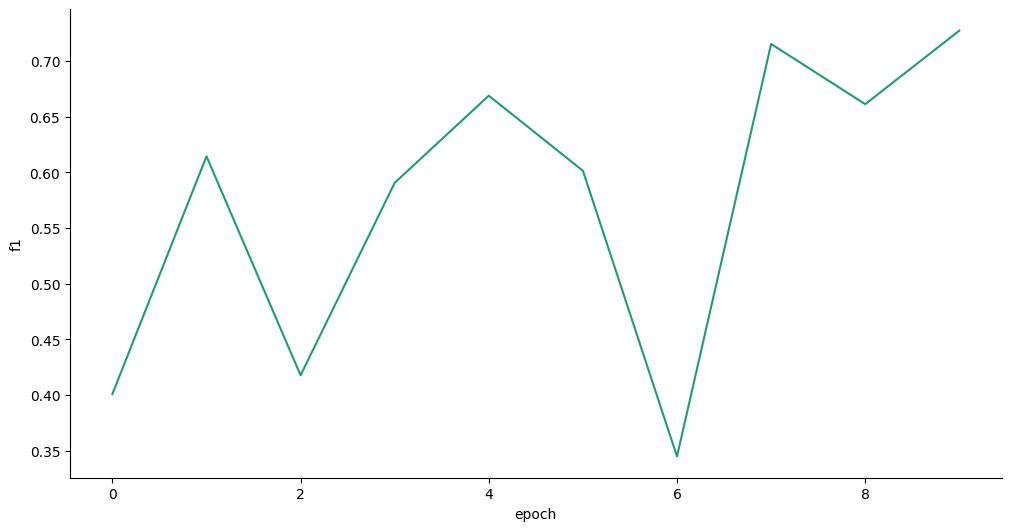

In [8]:
# @title epoch vs f1

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['epoch']
  ys = series['f1']

  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = history.sort_values('epoch', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('epoch')
_ = plt.ylabel('f1')

Note that the above plot has been generated with the help of AI.

Also note that we only ran 10 epochs just to quickly check if the changes we made to the finetuning trainer code had the effect to expose `f1`. The short answer is yes.

We should compare this plot to Figure 3(a) in the paper, since our proposed reproduction will be pretrain on the beat classification problem. (Actually we could pick any of the 4 subplots in Figure 3 as this is the random initialization plot we are comparing to, and all 4 subplots appear to show the same f1 curve)

I would have to say that the above plot looks on track with Figure 3(a).



Next, we explore (2) which is the `history.npy` file that is saved after `model.fit()` is complete.

In [14]:
# source: https://stackoverflow.com/a/61328750
import numpy as np

model_history = np.load('history.npy', allow_pickle=True).item()

In [15]:
model_history.keys()

dict_keys(['loss', 'acc', 'val_loss', 'val_acc', 'f1'])

In [16]:
model_history['f1']

[0.40085603011134924,
 0.6145307633171481,
 0.4177190766723688,
 0.5907259013641992,
 0.6690685741572123,
 0.601569550897282,
 0.34476060422968285,
 0.7155440768462392,
 0.6614180719390316,
 0.7275352297905606]

We also get `f1` saved here as well!

Q: Does this `f1` match the one in `history.csv`?

A: Yes, see below assert call

In [21]:
np.testing.assert_array_almost_equal(history['f1'], model_history['f1'])